<a href="https://colab.research.google.com/github/IlyaKo4atkov/My-machine-learning-projects/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B8_%D0%BC%D1%83%D0%B7%D1%8B%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

## Разработал модель нейронной сети, которая умеет сочинять музыку на основе датасета произведений классической музыки.

### Загрузка необходимых библиотек

In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21

!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

### Импорт необходимых библиотек

In [ ]:
from music21 import *

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

# Импортируем библиотеки
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.optimizers import Adamax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

### Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip

# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset

!dir ./dataset

CLASS_LIST=["Chopin"]

--2024-10-29 19:19:30--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  1.83MB/s    in 1.4s    

2024-10-29 19:19:33 (1.83 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [ ]:

all_midis = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i

            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis.append(midi)

### Функция для преобразования потока в список нот

In [ ]:
def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [ ]:
Corpus = getNotes(all_midis)
print("Всего нот во всех midi-файлах всего датасета:", len(Corpus))

print("Первые 50 нот в корпусе:", Corpus[:50])

Всего нот во всех midi-файлах всего датасета: 57894
Первые 50 нот в корпусе: ['1', '4', '4', '8.1', 'C#3', 'C#3', 'E-3', 'A3', '5', 'C#4', '0', 'E-3', 'A3', '5', '10', 'F3', '10.1', 'F2', '10', 'F3', '10.1', 'F2', '10', 'F3', '10.1', 'F2', '10', 'F3', '10.1', 'F2', '10', 'F3', '10.1', 'F2', '10', 'F3', '10.1', 'F2', '10', 'F3', '10.1', 'F2', '10', 'F3', '10.1', 'F3', 'C#5', 'B-2', 'B-4', 'F3']


### Функцция создания нотного стана

In [ ]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1


    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(Corpus[:100])
Melody_midi = stream.Stream(Music)

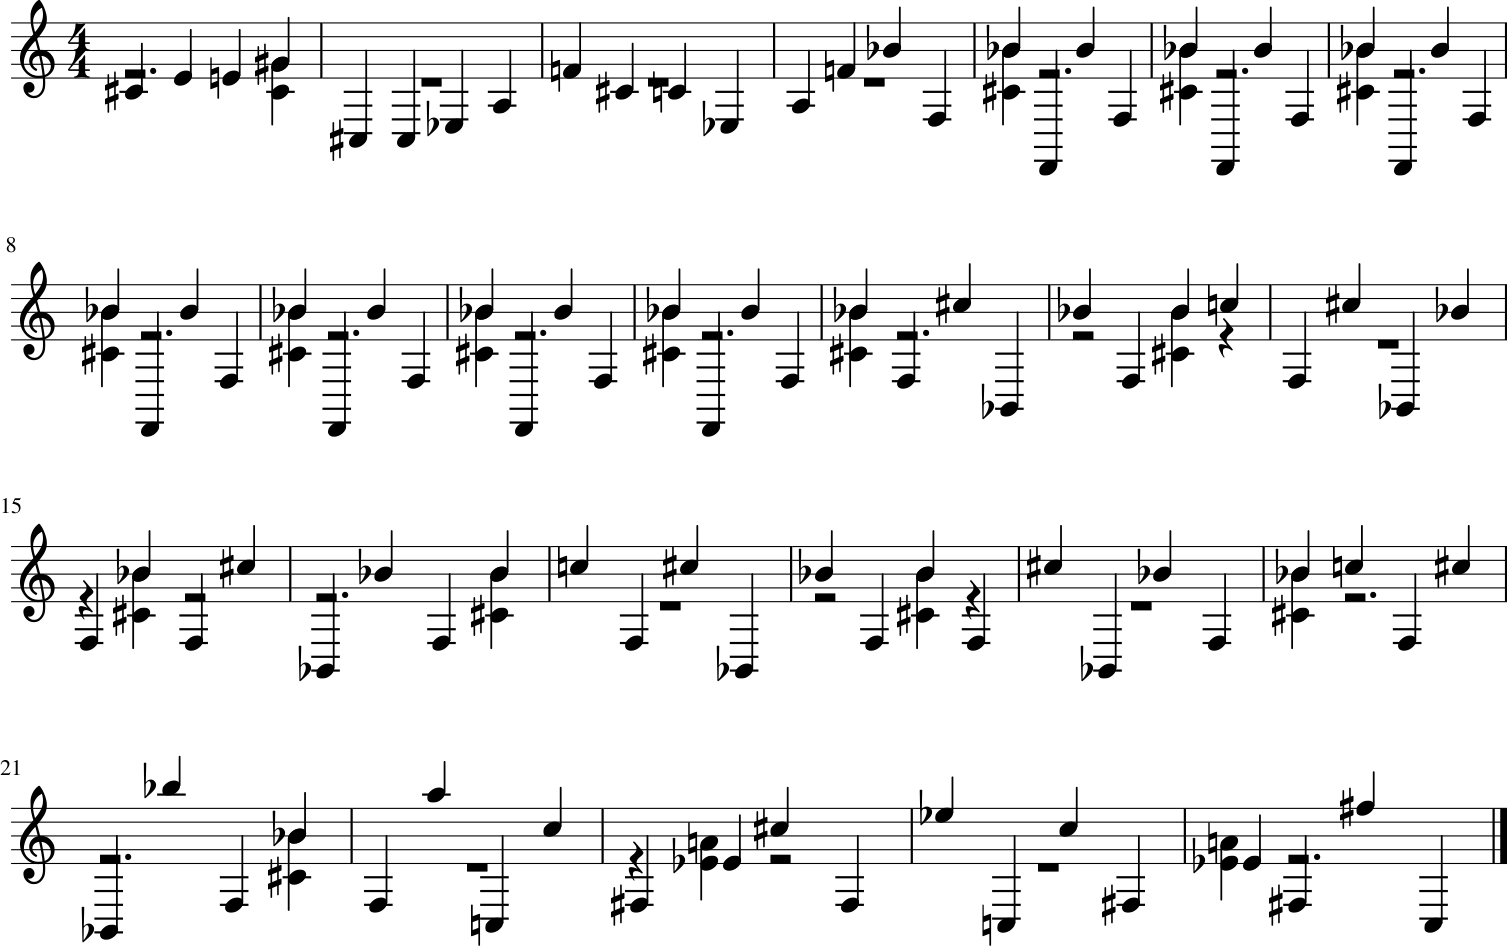

In [ ]:
# Отобразим нотный стан
Melody_midi.show()

In [ ]:
# Выведем в виде звуковой дорожки
Melody_midi.show('midi')

### Отбор уникальных нот в корпусе

In [ ]:
from collections import Counter
count_num = Counter(Corpus)
print("Общее число уникальных нот в корпусе:", len(count_num))

Общее число уникальных нот в корпусе: 397


In [ ]:
#Распределение нот в корпусе
# Ключ в словаре - имена нот
# Значение в словаре - их количество

Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 145.8287153652393
Наиболее часто встречаемые ноты: 1627 раз
Наиболее редкие ноты: 1 раз


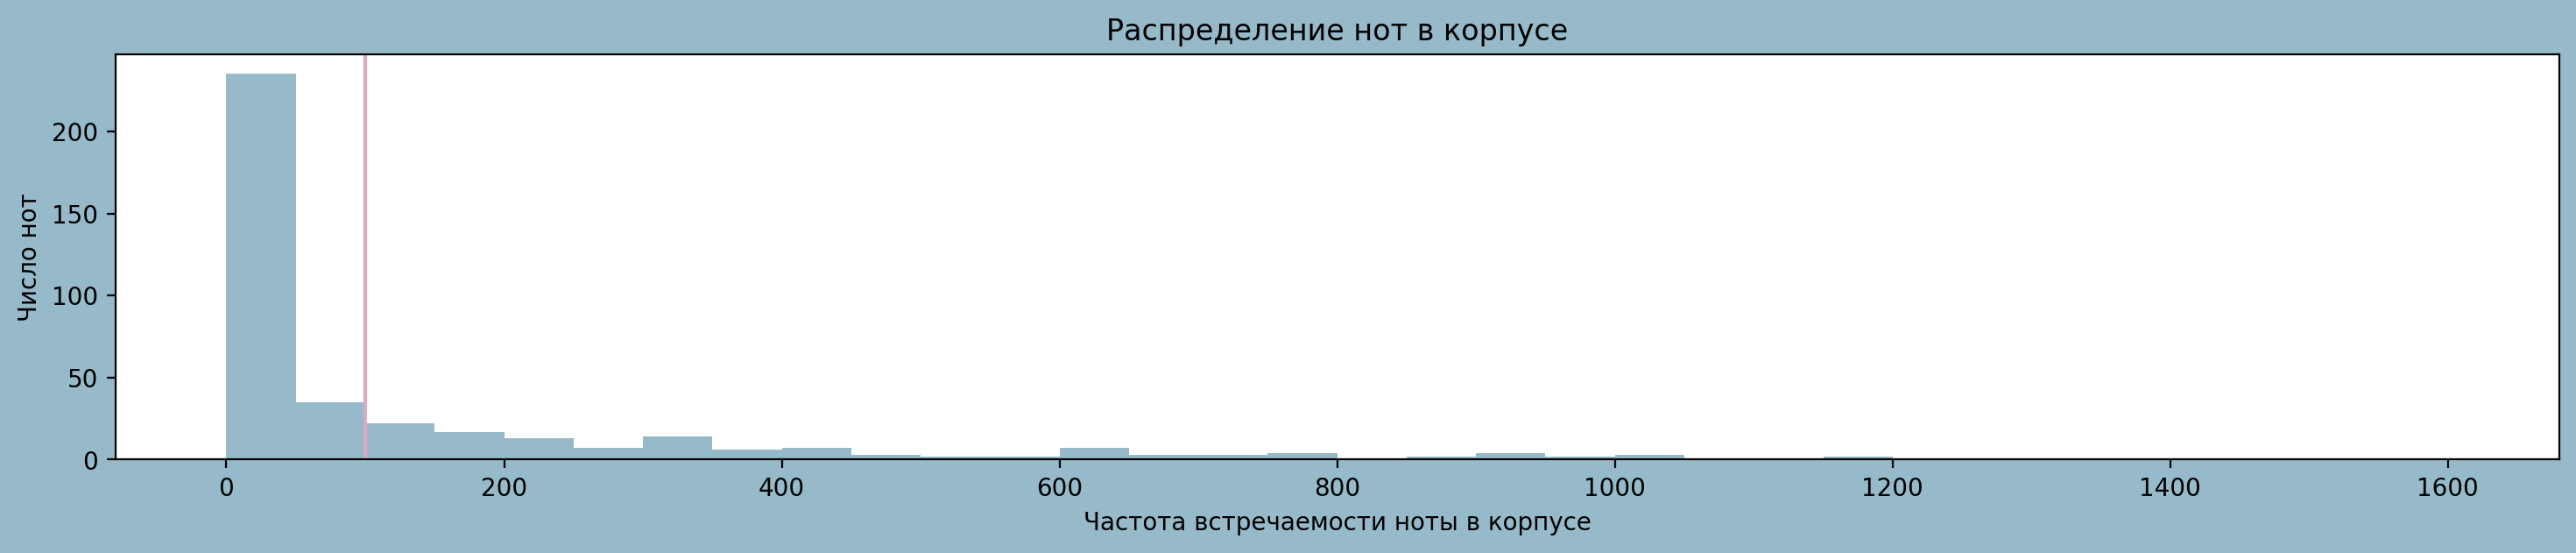

In [ ]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [ ]:
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 270


In [ ]:
#удаление редких нот
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Длина корпуса после исключения редких нот:", len(Corpus))

Длина корпуса после исключения редких нот: 53745


### Предобработка данных

In [ ]:
# Сохраняем все уникальные значения корпуса
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # длина корпуса
L_symb = len(symb) # число уникальных элементов корпуса

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Общее число символов:", L_corpus)
print("Число уникальных символов:", L_symb)

Общее число символов: 53745
Число уникальных символов: 255


### Кодирование и разбиение корпуса

In [ ]:
# Разбиение корпуса на равные входные строки и выходные целевые последовательности

# длинны последовательностей
length = 40

# входные последовательности
features = []

# целевые последовательности
targets = []

# цикл разбиения корпуса
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Общее количество последовательностей в корпусе:", L_datapoints)

Общее количество последовательностей в корпусе: 53705


### Нормализация данных

In [ ]:
# изменение размера и нормализация входных данных
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one-hot encode для целевых выходных данных
y = tensorflow.keras.utils.to_categorical(targets)

print(f'Форма входных данных: {X.shape}')
print(f'Форма выходных данных: {y.shape}')

Форма входных данных: (53705, 40, 1)
Форма выходных данных: (53705, 255)


In [ ]:
#Разделение выборки
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)



---



## Загрузка данных и создание корпуса для генерации произведения Моцарта







In [ ]:

CLASS_LIST_TRAIN=["Mozart"]

all_midis = []
for compositor in CLASS_LIST_TRAIN:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i

            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis.append(midi)

def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

Corpus = getNotes(all_midis)

# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1


    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(Corpus[:100])
Melody_midi = stream.Stream(Music)


# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

# Сохраняем все уникальные значения корпуса
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # длина корпуса
L_symb = len(symb) # число уникальных элементов корпуса

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

# Разбиение корпуса на равные входные строки и выходные целевые последовательности

# длинны последовательностей
length = 40

# входные последовательности
features = []

# целевые последовательности
targets = []

# цикл разбиения корпуса
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
#Нормализация данных
# изменение размера и нормализация входных данных
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one-hot encode для целевых выходных данных
y = tensorflow.keras.utils.to_categorical(targets)

X_train, X_seed_train, y_train, y_seed_train = train_test_split(X, y, test_size=0.2, random_state=42)

### Построение архитектуры нейронной сети

In [ ]:
model = Sequential()

model.add(LSTM(256, input_shape=X.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=150)

Epoch 1/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - acc: 0.0251 - loss: 4.8280
Epoch 2/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0360 - loss: 4.4648
Epoch 3/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0380 - loss: 4.4396
Epoch 4/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0388 - loss: 4.4312
Epoch 5/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0397 - loss: 4.4185
Epoch 6/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - acc: 0.0414 - loss: 4.3999
Epoch 7/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - acc: 0.0412 - loss: 4.3925
Epoch 8/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.0421 - loss: 4.3704
Epoch 9/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - acc: 0.0423 - loss: 4.3539
Epoch 10/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.0447 - loss: 4.3468
Epoch 11/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0486 - loss: 4.3147
Epoch 12/150
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.0530 - loss: 4.2962
E

### Оценка результатов обучения

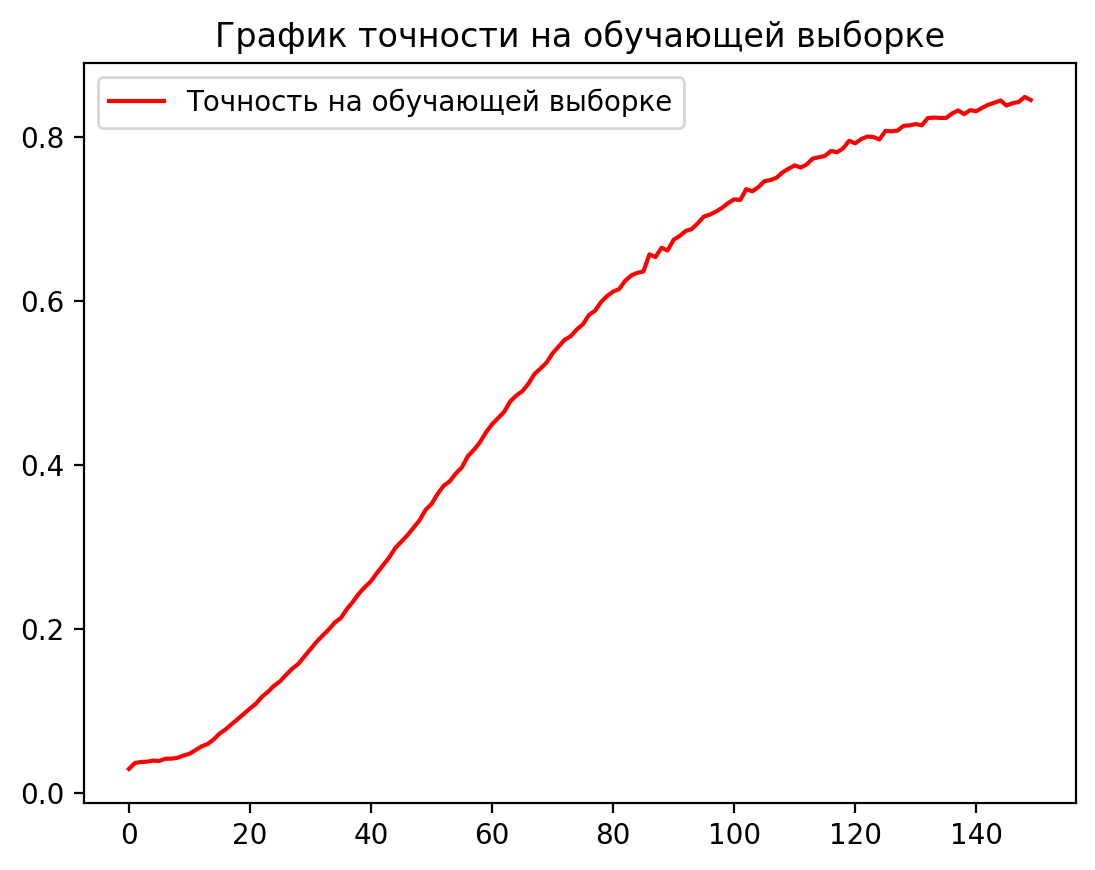

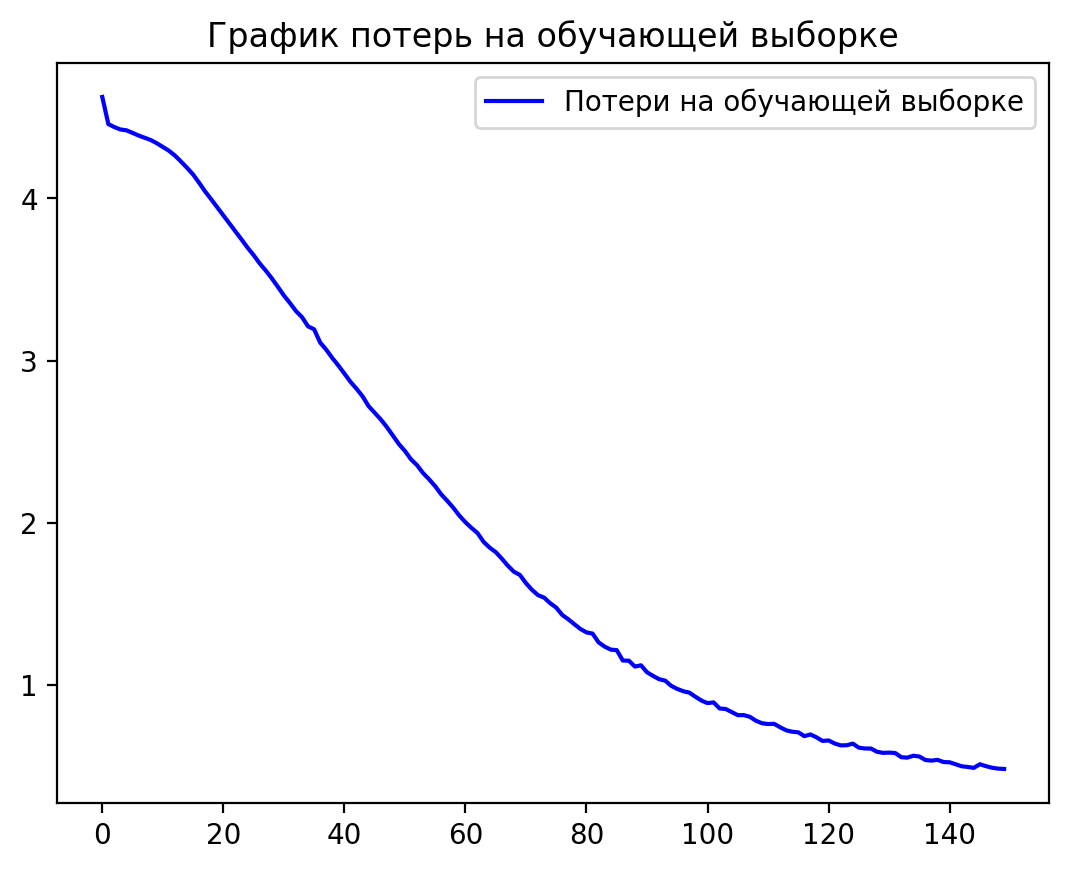

In [ ]:
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

### Генерация музыкального произведения

In [ ]:
def music_generator(seq_len):
    # случайный выбор начальной последовательности
    seed_train = X_seed_train[np.random.randint(0, len(X_seed_train)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed_train = seed_train.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed_train, verbose=0)[0]

        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed_train = np.insert(seed_train[0], len(seed_train[0]), index_N)
        seed_train = seed_train[1:]

    return chords_n_notes(music)



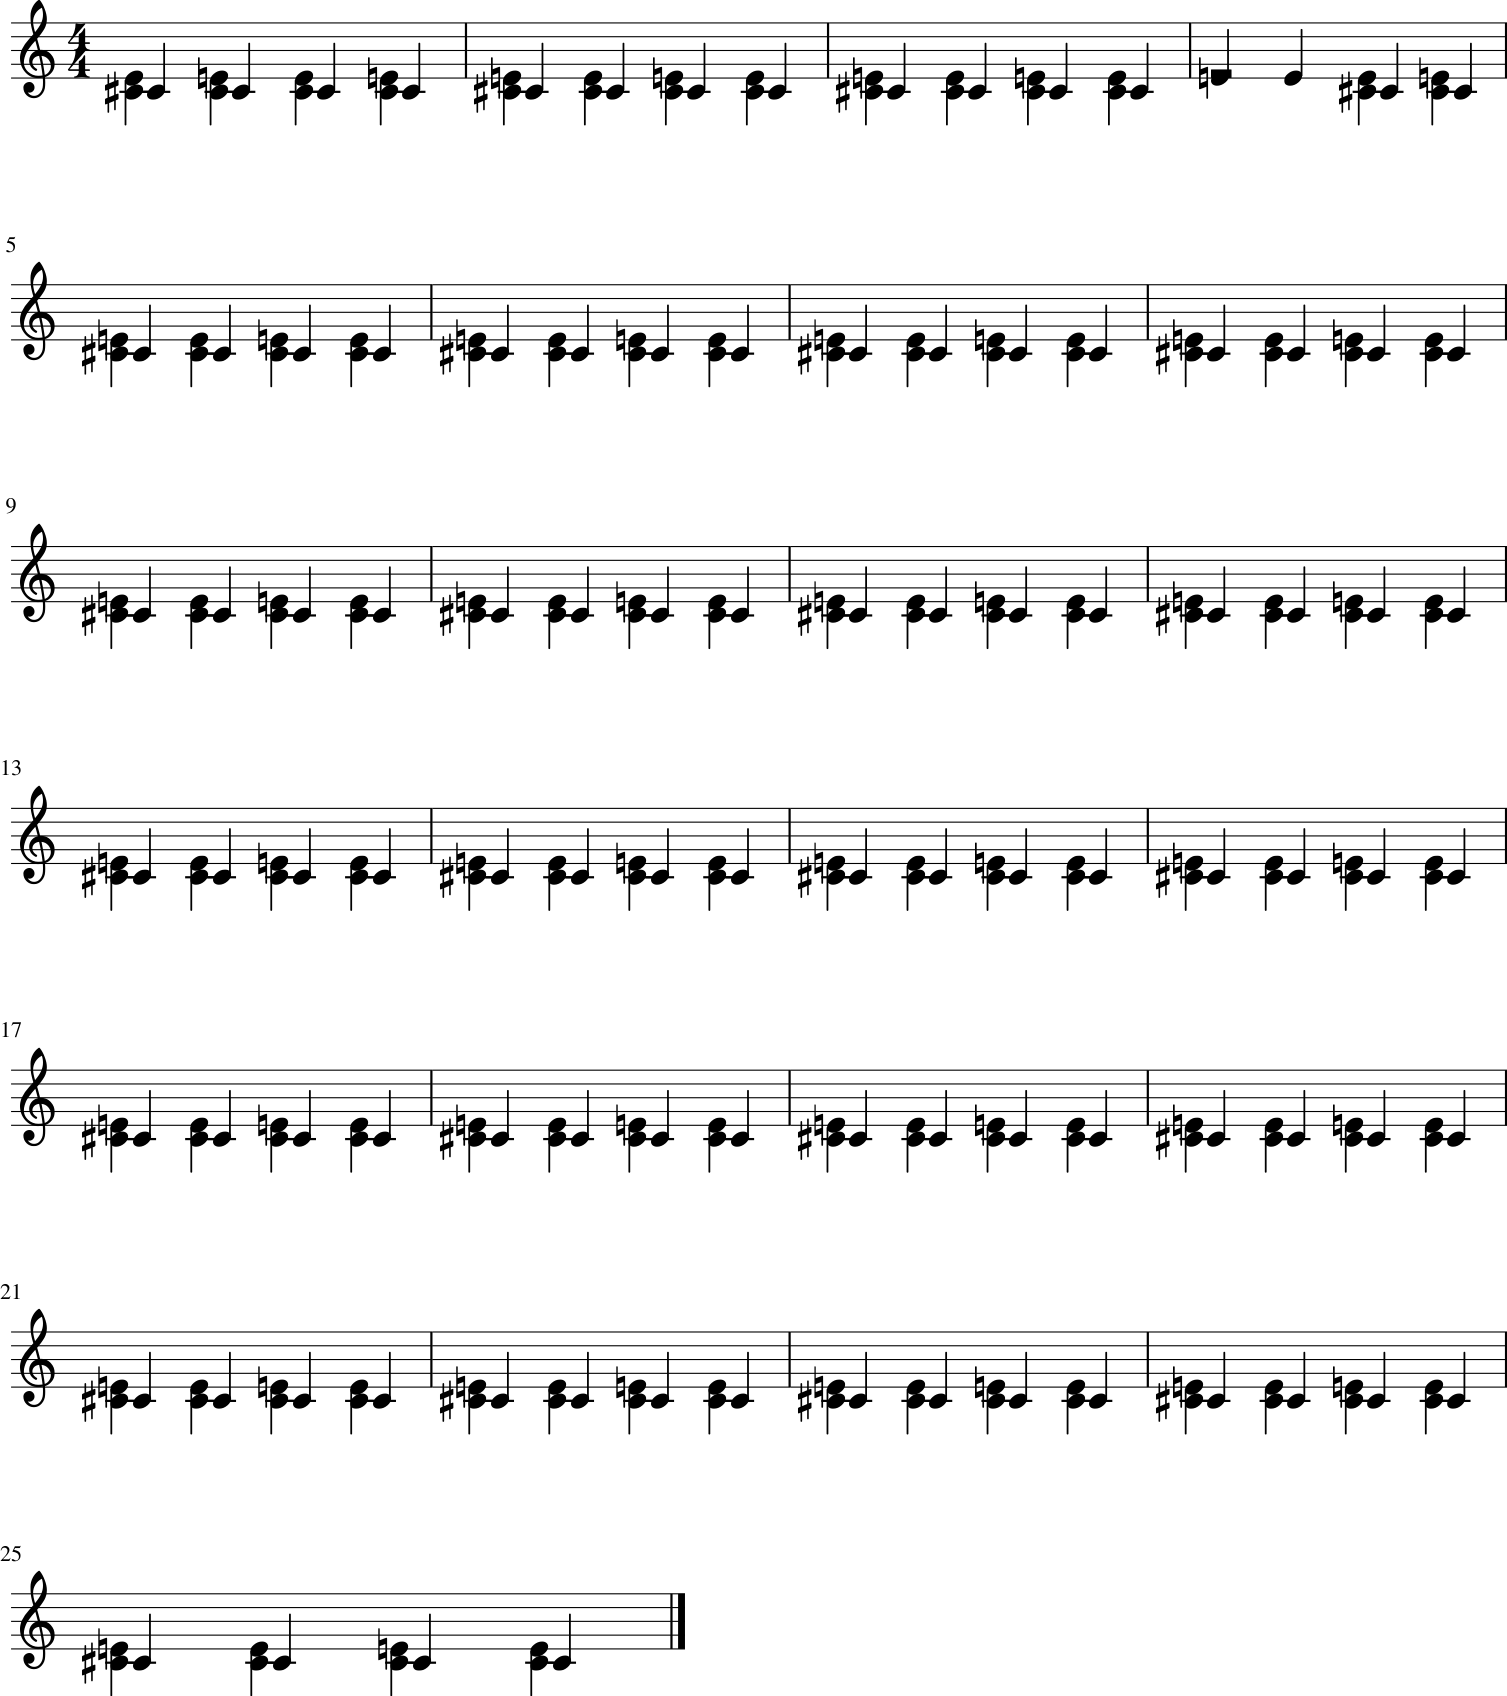

In [ ]:
genMusic = music_generator(100)
genMidi = stream.Stream(genMusic)

# Отобразим нотный стан
genMidi.show()

In [ ]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')

### Проведения операции улучшения результата генерации с использованием параметров pitch, step, duration

In [ ]:
# установим библиотеку для извлечения данных из MIDI
!pip install pretty_midi

# импортируем загруженную библиотеку для работы с MIDI
import pretty_midi


In [ ]:
# функция преобразования MIDI в DataFrame, содержащий ноты и их расширенные параметры
def midi_to_notes(midi_file: str):
  # чтение MIDI
  pm = pretty_midi.PrettyMIDI(midi_file)
  # извлечение первого инструмента
  instrument = pm.instruments[0]

  # объявляем список для хранения нот
  notes = []
  # сортируем ноты по времени начала ноты
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)

  # переменная для расчета шага, хранит предущее значение start
  prev_start = sorted_notes[0].start # начало первой ноты

  for note in sorted_notes:
    # начало ноты
    start = note.start
    # конец ноты
    end = note.end
    notes.append(
        dict(
            pitch=note.pitch,             # имя ноты
            start=note.start,             # начало ноты
            end=note.end,                 # конец ноты
            step=(start - prev_start),    # шаг
            duration=(end - start)        # длительность ноты
        )
    )

    prev_start = start # запоминаем значение предыдущего старта

  return pd.DataFrame(notes) # функция возвращает значение DataFrame библиотеки pandas

In [ ]:

#Преобразование миди файла
midi_file_path = "generated_music.mid"

genMidi.write('midi', fp=midi_file_path)

# Преобразование MIDI в DataFrame
notes_df = midi_to_notes(midi_file_path)

#преобразуем в ноты с расширенными параметрами
raw_notes = midi_to_notes(midi_file_path)

# Вывод первых 5 строк
raw_notes.head()

,pitch,start,end,step,duration
0,61,0.0,0.5,0.0,0.5
1,61,0.0,0.5,0.0,0.5
2,64,0.0,0.5,0.0,0.5
3,61,0.5,1.0,0.5,0.5
4,61,0.5,1.0,0.0,0.5


In [ ]:
from keras.utils import to_categorical

def generate_data(pitch, step, duration):
    time_steps = np.arange(step)
    X = []
    y = []
    for t in time_steps:
        # Создания входных данных
        X.append([pitch, t * duration, duration])
        # создания меток (следующая высота звука)
        y.append(pitch + 1)  #
    return np.array(X), np.array(y)

# Генерация данных
X, y = generate_data(pitch=75, step=0.5, duration=0.5) # для того что бы продемонстрировать работу функции с параметрами pitch, step, duration, выбрал случайные значения из таблицы

# Преобразование данных для модели
X = X.reshape((X.shape[0], 1, X.shape[1]))  # reshape для LSTM
y = np.eye(np.max(y) + 1)[y]  # One-hot encoding меток


In [ ]:
# Повторное Создание и обучение модели, но уже с применением параметров pitch, step, duration
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
history = model.fit(X, y, batch_size=256, epochs=100)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.0000e+00 - loss: 4.2743
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - acc: 1.0000 - loss: 4.0477
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 1.0000 - loss: 3.8586
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - acc: 1.0000 - loss: 3.6785
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - acc: 1.0000 - loss: 3.2424
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - acc: 1.0000 - loss: 3.0044
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - acc: 1.0000 - loss: 2.6626
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - acc: 1.0000 - loss: 2.4077
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - acc: 1.0000 - loss: 1.8060
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - acc: 1.0000 - loss: 1.5136
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - acc: 1.0000 - loss: 0.8753
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 1.0000 - loss: 0.4879
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
def music_generator(seq_len):
    # случайный выбор начальной последовательности
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]

        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)



In [ ]:
# Выведем результат сгенерированного
genMidi.show('midi')